(mmm_causal_ladder)=
# MMMs and Pearl's ladder of causal inference

In this notebook, we will explore [Judea Pearl's](https://en.wikipedia.org/wiki/Judea_Pearl) causal ladder and how it can be applied to solve business problems with Media Mix Models (MMMs). We will assume familiarity with the basics of MMMs in order to focus on causal inference.

## What is Pearl's causal ladder?

Pearl's causal ladder outlines 3 successively more sophisticated levels of causal reasoning:

1. **Prediction / Forecasting / Association:** With the first step on the ladder, we could use a model to predict future sales based on past data. This does not involve causal reasoning, just prediction.

2. **Intervention:** The second step on the ladder involves using a model to predict the future effect of an intervention. It is similar to step 1 in that it involves prediction/forecasting, but it is different in that we consder a potential intervention that will have effects in the future.

3. **Counterfactuals:** The third and final step on the ladder could use a to estimate how the world _would_ have been different if we had taken a different action in the past. This is clearly different from the first two steps in that it is retrospective. It is also the most sophisticated level of causal reasoning - it involves learning about the world from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario.

![Causal Ladder](../../_static/causal_ladder.png)

## The do-operator

The do-operator is a key concept in Pearl's causal inference framework and is required for causal reasoning on Step 2 or 3 of the causal ladder. It is used to denote interventions in a system. If we think about our modeling efforts as describing a Bayesian structural causal model, then the do-operator is used to denote the effect of changing a variable in the model. Any incoming causal links to that node are severed, and the node is set to the value specified by the do-operator.

:::{seealso}
For practical examples of the do-operator in action, the following resources are useful:
* [Causal analysis with PyMC: Answering "What If?" with the new do operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/)
* [Interventional distributions and graph mutation with the do-operator](https://www.pymc.io/projects/examples/en/latest/causal_inference/interventional_distribution.html)
:::

## How does this help us solve business problems?

Now we've recapped the causal ladder, let's consider how it can help us solve business problems, specifically with MMMs. Let's look at a few example use cases and see what level of the causal ladder they correspond to:

* **Predicting future sales:** A very common use-case of MMM's is to make forecasts of our outcome variable (e.g. sales). This can be particularly useful ingredient in demand forecasting for example. Once we've trained an MMM on historical data we can use the MMM to predict future sales (out of sample prediction) based on past sales, marketing spend, and other predictor variables. This would correspond to step 1 on the causal ladder - we are forecasting into the future but not considering any changes to our marketing strategy.

* **Optimizing existing marketing spend:** A more sophisticated use-case of MMM's is to use the model to predict the effect of different marketing strategies. For example, we could use it to predict the effect of various different changes to media spend. We could then predict the expected sales under these scenarios and pick a scenario which maximises sales or profit, for example. This corresponds to step 2 on the causal ladder - intervention. This is a more sophisticated level of causal reasoning, as it involves prediction, but in the presence of an altered marketing strategies (i.e. interventions).

* **Planning an increase in marketing spend:** Let's say our business wants to gain more market share and has decided to increase marketing spend by 20% over the next quarter. You are tasked with proposing a number of different future media spend strategies that you think will cause the largest increase in sales. This corresponds to step 2 on the causal ladder - intervention. We are predicting the effect of an intervention (increasing media spend) on sales.

* **Evaluating the impact of a previous increase in marketing spend:** Let's say our business increased TV spend by 20% over the last quarter and we want to know what impact this had on sales. We can answer this question by comparing what _actually_ happened, to what we think _would have happened_ under some alternative imagined counterfactual scenario such as not increasing TV spend by 20%. Importantly, this counterfactual reasoning is _retrospective_, but it uses the knowledge we have learnt from all observations so far. This corresponds to step 3 on the causal ladder - counterfactual inference. We are learning from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario. So this involves retrospective causal reasoning.

## Notebook setup

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["figure.figsize"] = [12, 7]
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Level 1 - Prediction

We can use MMM's to predict future sales based on what we have learnt from historical data. This is a common use-case of MMM's and corresponds to step 1 on the causal ladder.

**_TODO: I have not yet decided if I'll include an example here. Regardless, I'll reference other notebooks._**

:::{seealso}
For the sake of brevity, and to avoid duplication, we will not walk through the process here. It is covered in detail in the {ref}`mmm_example` (see section on out of sample prediction) and also the notebook on {ref}`mmm_time_slice_cross_validation`.
:::

## Level 2 - Intervention

**_TODO: I have not yet decided if I'll include an example here. Regardless, I'll reference the budget allocation notebook._**

:::{seealso}
For much more information on using Level 2 of the causal ladder, see the dedicated notebook on {ref}`mmm_budget_allocation_example`.
:::

## Level 3 - Counterfactual inference

To signpost what we are going to do, the broad steps are as follows:

* Generate simulated data from both an _actual_ scenario where we conducted a marketing campaign, and a _counterfactual_ scenario where we did not conduct the marketing campaign. To be clear, we can never directly observe the counterfactual scenario (whatever it may be) because it is a hypothetical scenario. This is also known as the [fundamental problem of causal inference](https://en.wikipedia.org/wiki/Rubin_causal_model). However, when we invove "God Mode", we can simulate both actual and counterfactual scenarios.
* Train an MMM on _all_ the actual data - this will include data from before the marketing intervention, during the campaign, and also after the campaign.
* We can then use the MMM to predict what would have happened in the counterfactual scenario. This is the key step - we are using the MMM to predict what would have happened if we had not conducted the marketing campaign. This step involves using the do-operator (see above) to intervene upon the DAG.
* We can then compare the actual and counterfactual scenarios to estimate the effect of the marketing campaign.

:::{admonition} Parameter estimation
:class: note

The logic of running through these steps on simulated actual and counterfactual data is that we can compare the MMM's ability to estimate the causal impact of the marketing campaign to the true causal impact that we know because we simulated the data. If we do ok here, we can be more confident that the MMM will be able to estimate the causal impact of the marketing campaign on real data where only the actual data is available.
:::

### Generating synthetic 'actual' and 'counterfactual' data

Taken from [https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html).

In [4]:
def forward_pass(df_in):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns `x1` and `x2`, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    n = df.shape[0]

    # apply geometric adstock transformation
    alpha1: float = 0.4
    alpha2: float = 0.2

    df["x1_adstock"] = (
        geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    df["x2_adstock"] = (
        geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    # apply saturation transformation
    lam1: float = 4.0
    lam2: float = 3.0

    df["x1_adstock_saturated"] = logistic_saturation(
        x=df["x1_adstock"].to_numpy(), lam=lam1
    ).eval()

    df["x2_adstock_saturated"] = logistic_saturation(
        x=df["x2_adstock"].to_numpy(), lam=lam2
    ).eval()

    # trend and seasonality
    df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

    df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

    # random events
    df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
    df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

    df["intercept"] = 2.0
    if "epsilon" not in df.columns:
        df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

    amplitude = 1
    beta_1 = 3.0
    beta_2 = 2.0

    # forward pass
    df["y"] = amplitude * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + 1.5 * df["event_1"]
        + 2.5 * df["event_2"]
        + beta_1 * df["x1_adstock_saturated"]
        + beta_2 * df["x2_adstock_saturated"]
        + df["epsilon"]
    )
    return df


def generate_counterfactual_dataset(rng):
    """Generate a synthetic dataset.

    For the counterfactual scenario of no advertising campaign.
    """
    # date range
    min_date = pd.to_datetime("2019-04-01")
    max_date = pd.to_datetime("2021-09-01")

    df = pd.DataFrame(
        data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
    ).assign(
        year=lambda x: x["date_week"].dt.year,
        month=lambda x: x["date_week"].dt.month,
        dayofyear=lambda x: x["date_week"].dt.dayofyear,
    )

    n = df.shape[0]
    print(f"Number of observations: {n}")

    # media data
    x1 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

    x2 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x2"] = np.where(x2 > 0.8, x2, 0)

    df = forward_pass(df)

    # add a colulmn for the time index
    df["t"] = range(n)

    return df

In [5]:
df_counterfactual = generate_counterfactual_dataset(rng)
df_counterfactual.head()

Number of observations: 127


,date_week,year,month,dayofyear,x1,x2,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,epsilon,y,t
0,2019-04-01,2019,4,91,0.318580,0.0,0.191273,0.0,0.364917,0.0,0.778279,-0.012893,0.006446,-0.003223,0.0,0.0,2.0,0.079450,3.949257,0
1,2019-04-08,2019,4,98,0.112388,0.0,0.143987,0.0,0.280268,0.0,0.795664,0.225812,-0.113642,0.056085,0.0,0.0,2.0,-0.205876,3.486678,1
2,2019-04-15,2019,4,105,0.292400,0.0,0.233150,0.0,0.435205,0.0,0.812559,0.451500,-0.232087,0.109706,0.0,0.0,2.0,0.067992,4.295871,2
3,2019-04-22,2019,4,112,0.071399,0.0,0.136127,0.0,0.265721,0.0,0.828993,0.651162,-0.347175,0.151993,0.0,0.0,2.0,0.434727,4.212877,3
4,2019-04-29,2019,4,119,0.386745,0.0,0.286650,0.0,0.517779,0.0,0.844997,0.813290,-0.457242,0.178024,0.0,0.0,2.0,-0.040233,4.536124,4


Now generate a dataframe for the _actual_ situation where an experimental intervention took place. This will be a period of time where media spend was increased.

In [6]:
def generate_actual_dataset(
    df_counterfactual: pd.DataFrame, intervention_dates
) -> pd.DataFrame:
    """Generate the 'actual' dataset.

    Based on the counterfactual dataset, apply the intervention on the specified date
    and return the actual dataset.
    """
    df = df_counterfactual[
        ["t", "date_week", "dayofyear", "x1", "x2", "epsilon"]
    ].copy()
    # increase x1 by 40% in for date_week between intervention_dates
    df.loc[
        (df["date_week"] >= intervention_dates[0])
        & (df["date_week"] < intervention_dates[1]),
        "x1",
    ] *= 1.40
    # compute the outcome variable
    df = forward_pass(df)
    return df


intervention_dates = (pd.to_datetime("2021-01-01"), pd.to_datetime("2021-03-31"))
df_actual = generate_actual_dataset(df_counterfactual, intervention_dates)
df_actual.head()

,t,date_week,dayofyear,x1,x2,epsilon,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,y
0,0,2019-04-01,91,0.318580,0.0,0.079450,0.191273,0.0,0.364917,0.0,0.778279,-0.012893,0.006446,-0.003223,0.0,0.0,2.0,3.949257
1,1,2019-04-08,98,0.112388,0.0,-0.205876,0.143987,0.0,0.280268,0.0,0.795664,0.225812,-0.113642,0.056085,0.0,0.0,2.0,3.486678
2,2,2019-04-15,105,0.292400,0.0,0.067992,0.233150,0.0,0.435205,0.0,0.812559,0.451500,-0.232087,0.109706,0.0,0.0,2.0,4.295871
3,3,2019-04-22,112,0.071399,0.0,0.434727,0.136127,0.0,0.265721,0.0,0.828993,0.651162,-0.347175,0.151993,0.0,0.0,2.0,4.212877
4,4,2019-04-29,119,0.386745,0.0,-0.040233,0.286650,0.0,0.517779,0.0,0.844997,0.813290,-0.457242,0.178024,0.0,0.0,2.0,4.536124


Let's make that more real by visualizing the `x1` and `x2` predictors, along with the `y` outcome variable. This is done for both the actual and counterfactual scenarios. We can see that there is divergence in the media spend in `x1` during the campaign period and also for the outcome variable `y`. The difference between the outcome in the actual and counterfactual scenarios is the causal effect of the marketing campaign (bottom plot).

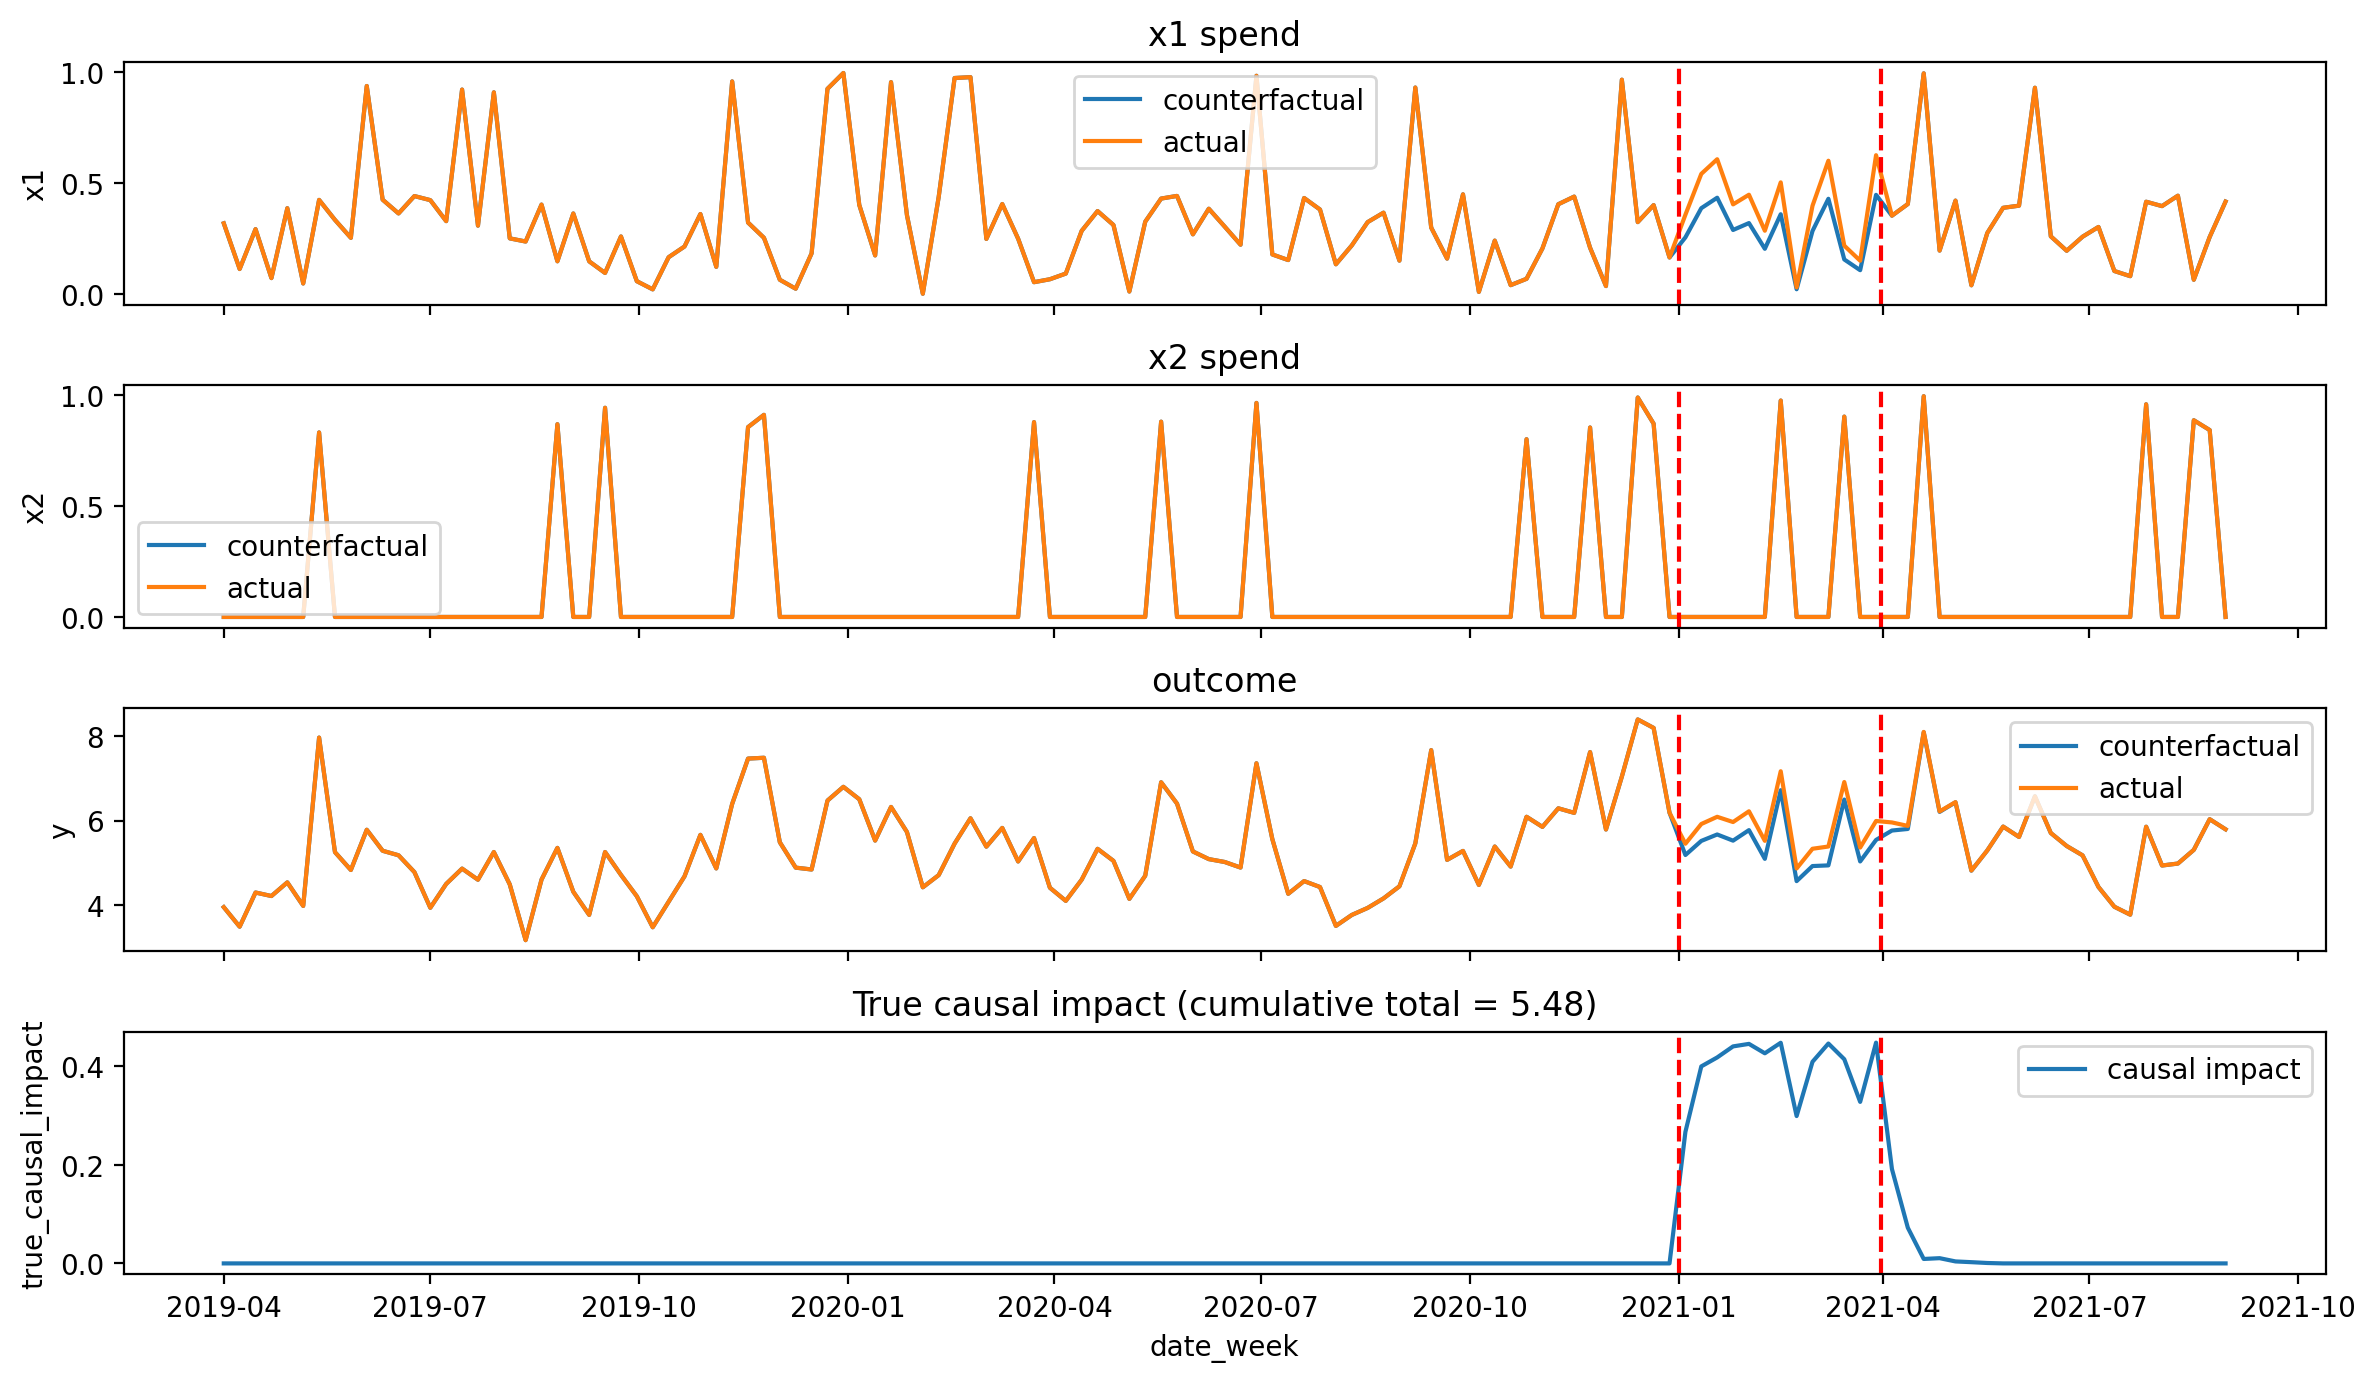

In [7]:
def plot_intervention_dates(intervention_dates, ax):
    ax.axvline(
        x=pd.to_datetime(intervention_dates[0]),
        color="red",
        linestyle="--",
        label="intervention date",
    )
    ax.axvline(
        x=pd.to_datetime(intervention_dates[1]),
        color="red",
        linestyle="--",
        label="intervention date",
    )


fig, ax = plt.subplots(4, 1, sharex=True)

sns.lineplot(
    x="date_week", y="x1", data=df_counterfactual, label="counterfactual", ax=ax[0]
)
sns.lineplot(x="date_week", y="x1", data=df_actual, label="actual", ax=ax[0])
ax[0].set(title="x1 spend")

sns.lineplot(
    x="date_week", y="x2", data=df_counterfactual, label="counterfactual", ax=ax[1]
)
sns.lineplot(x="date_week", y="x2", data=df_actual, label="actual", ax=ax[1])
ax[1].set(title="x2 spend")

sns.lineplot(
    x="date_week", y="y", data=df_counterfactual, label="counterfactual", ax=ax[2]
)
sns.lineplot(x="date_week", y="y", data=df_actual, label="actual", ax=ax[2])
ax[2].set(title="outcome")

# calculate true causal impact
new_df = pd.DataFrame()
new_df["date_week"] = df_actual["date_week"]
new_df["true_causal_impact"] = df_actual["y"] - df_counterfactual["y"]

sns.lineplot(
    x="date_week", y="true_causal_impact", data=new_df, label="causal impact", ax=ax[3]
)
cumulative_impact = new_df["true_causal_impact"].sum()
ax[3].set(title=f"True causal impact (cumulative total = {cumulative_impact:.2f})")

# plot intervention point
for i in [0, 1, 2, 3]:
    plot_intervention_dates(intervention_dates, ax[i])

plt.tight_layout();

Because we are simulating this world, we know the true causal impact. The next step will be to train an MMM on the actual data and then use it to estimate the causal impact of the marketing campaign.

:::{note}
Notice in the bottom plot that the causal impact of the campaign continues on for a short duration after the campaign as ended. This is a direct result of the adstock function in the MMM which models the lagged effect of media spend on sales. Similarly, there is a slight lag effect at the start of the campaign. There is also noise in the causal impact - this makes sense because the way how we similated this data was based on changes in media spend, not on a specified level of sales difference.
:::

### Train an MMM on the actual data

In the real world, we only have access to the df_actual data. Our goal will be to infer the causal impact of the intervention.

* Train MMM on data available to us in df_actual. This will include the whole time series available to us.
* Evaluate the model's predictions in the counterfactual world where the intervention did not take place.

This latter step involves graph manipulation via the do-operator. Because we are altering a 'data node' (rather than a random variable node) we can do this by using `pm.set_data`. We will it so that `x1` is equal to the spend in the counterfactual world where no intervention took place. 

:::{caution}
Stepping back, to get to our goal of counterfactual inference, we need to use the trained MMM to make predictions about the counterfactual scenario. In this particular case, that means specifying what the `x1` spend would have been in the absense of the media campaign. 

We are solving this here by simulating a world where we can know exactly what the counterfactual spend is. In real-world scenarios we may or may not know what the spend would have been. If our organisation tends to have predictable media spends and perhaps normally plans then quite far in advance then it may be trivial to construct what we would have spend on channel `x1` in the absense of the campaign. If we don't know what the counterfactual spend would have been, then we would need to estimate it. This could be done using a separate model, or by using some kind of counterfactual inference technique such as synthetic control.
:::

In [8]:
# construct an empty MMM model object
mmm = MMM(
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

Next, we will train the model on all of the 'actual' data.

In [9]:
# prepare data for model
X = df_actual.drop("y", axis=1)
y = df_actual["y"]

# fit the model - sample from the posterior
mmm.fit(X=X, y=y, target_accept=0.85, chains=4, random_seed=rng)

# posterior predictive sampling
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [y]


Output()

Before starting our procedure for counterfactual inference, let's first confirm that the MMM is doing a reasonable job of accounting for the data. Below is a plot of the posterior predictive distribution for the sales (shaded regions) and the actual sales (black line).

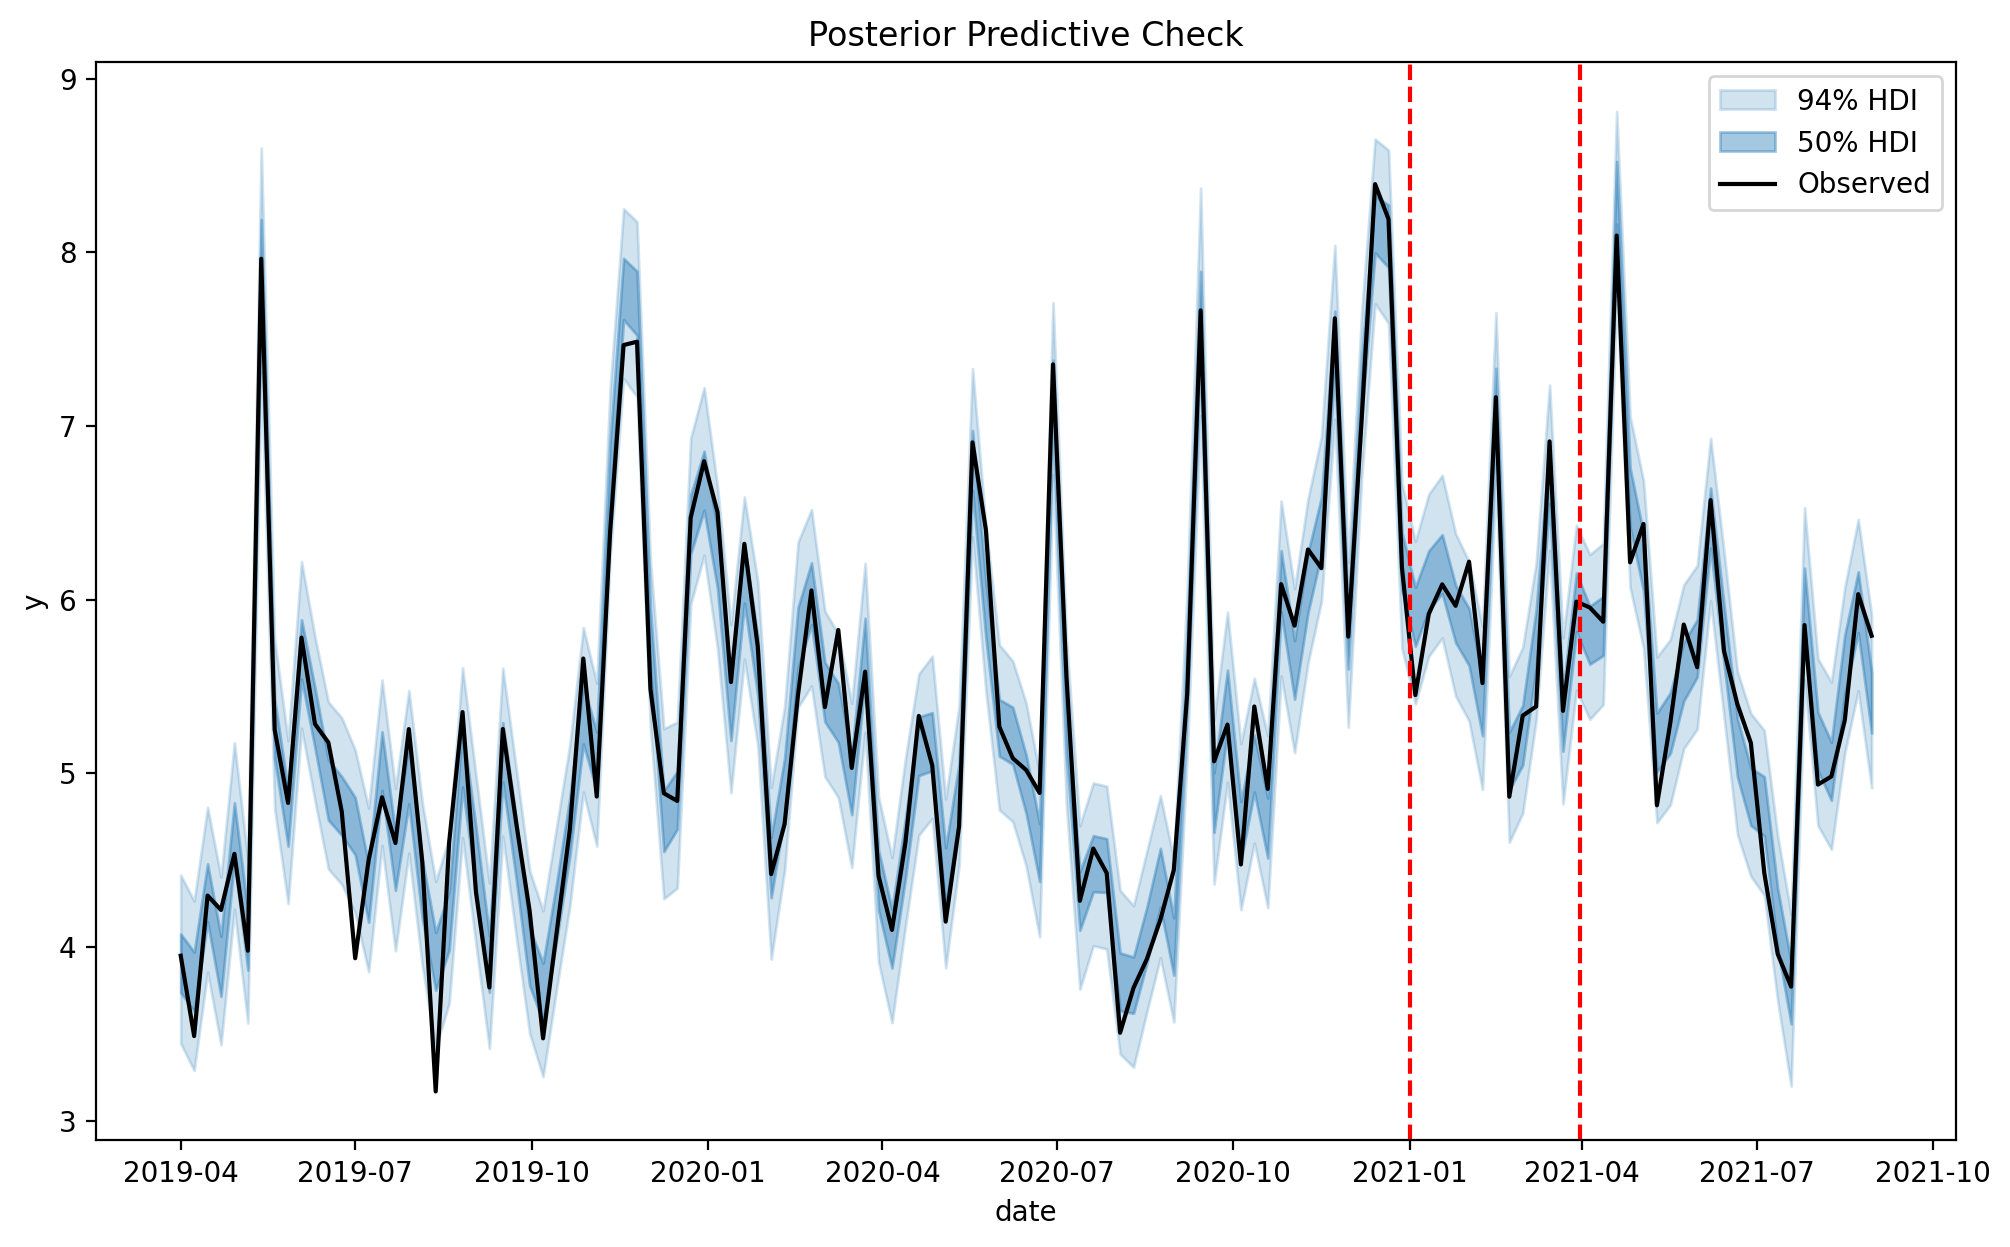

In [10]:
fig = mmm.plot_posterior_predictive(original_scale=True)
plot_intervention_dates(intervention_dates, fig.axes[0])

The model seems to be doing a good job of capturing the data so we can proceed with counterfactual inference.

### Counterfactual inference

Now we want to evaluate what the model thinks would have happened in the counterfactual scenario that the intervention did not take place. For this, we will use the counterfactual spend in `df_counterfactual.x1`. But remember, in a real-world scenario, we would not have access to this data and so we would have to estimate it as discussed above.

In [11]:
X_counterfactual = df_counterfactual[
    ["t", "date_week", "x1", "x2", "event_1", "event_2"]
]
X_counterfactual.head()

,t,date_week,x1,x2,event_1,event_2
0,0,2019-04-01,0.318580,0.0,0.0,0.0
1,1,2019-04-08,0.112388,0.0,0.0,0.0
2,2,2019-04-15,0.292400,0.0,0.0,0.0
3,3,2019-04-22,0.071399,0.0,0.0,0.0
4,4,2019-04-29,0.386745,0.0,0.0,0.0


The command below effectively uses the do-operator to intervene on the DAG and set `x1` to the counterfactual spend, and use the model to predict what the sales would have been in the counterfactual scenario.

In [12]:
y_counterfactual = mmm.sample_posterior_predictive(
    X_pred=X_counterfactual, extend_idata=False
);

Sampling: [y]


Output()

### Calculate the causal impact

Now we have the actual sales data, and our predicted sales in the counterfactual scenario, we can calculate the causal impact of the intervention. This is done by comparing the actual sales to the predicted sales in the counterfactual scenario.

In [13]:
y_obs = xr.DataArray(df_actual["y"].to_numpy(), dims=["date"])
causal_impact = y_obs - y_counterfactual["y"]

### Plot counterfactual predictions

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_86035/4115158321.py:9: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_86035/4115158321.py:24: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_86035/4115158321.py:46: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instea

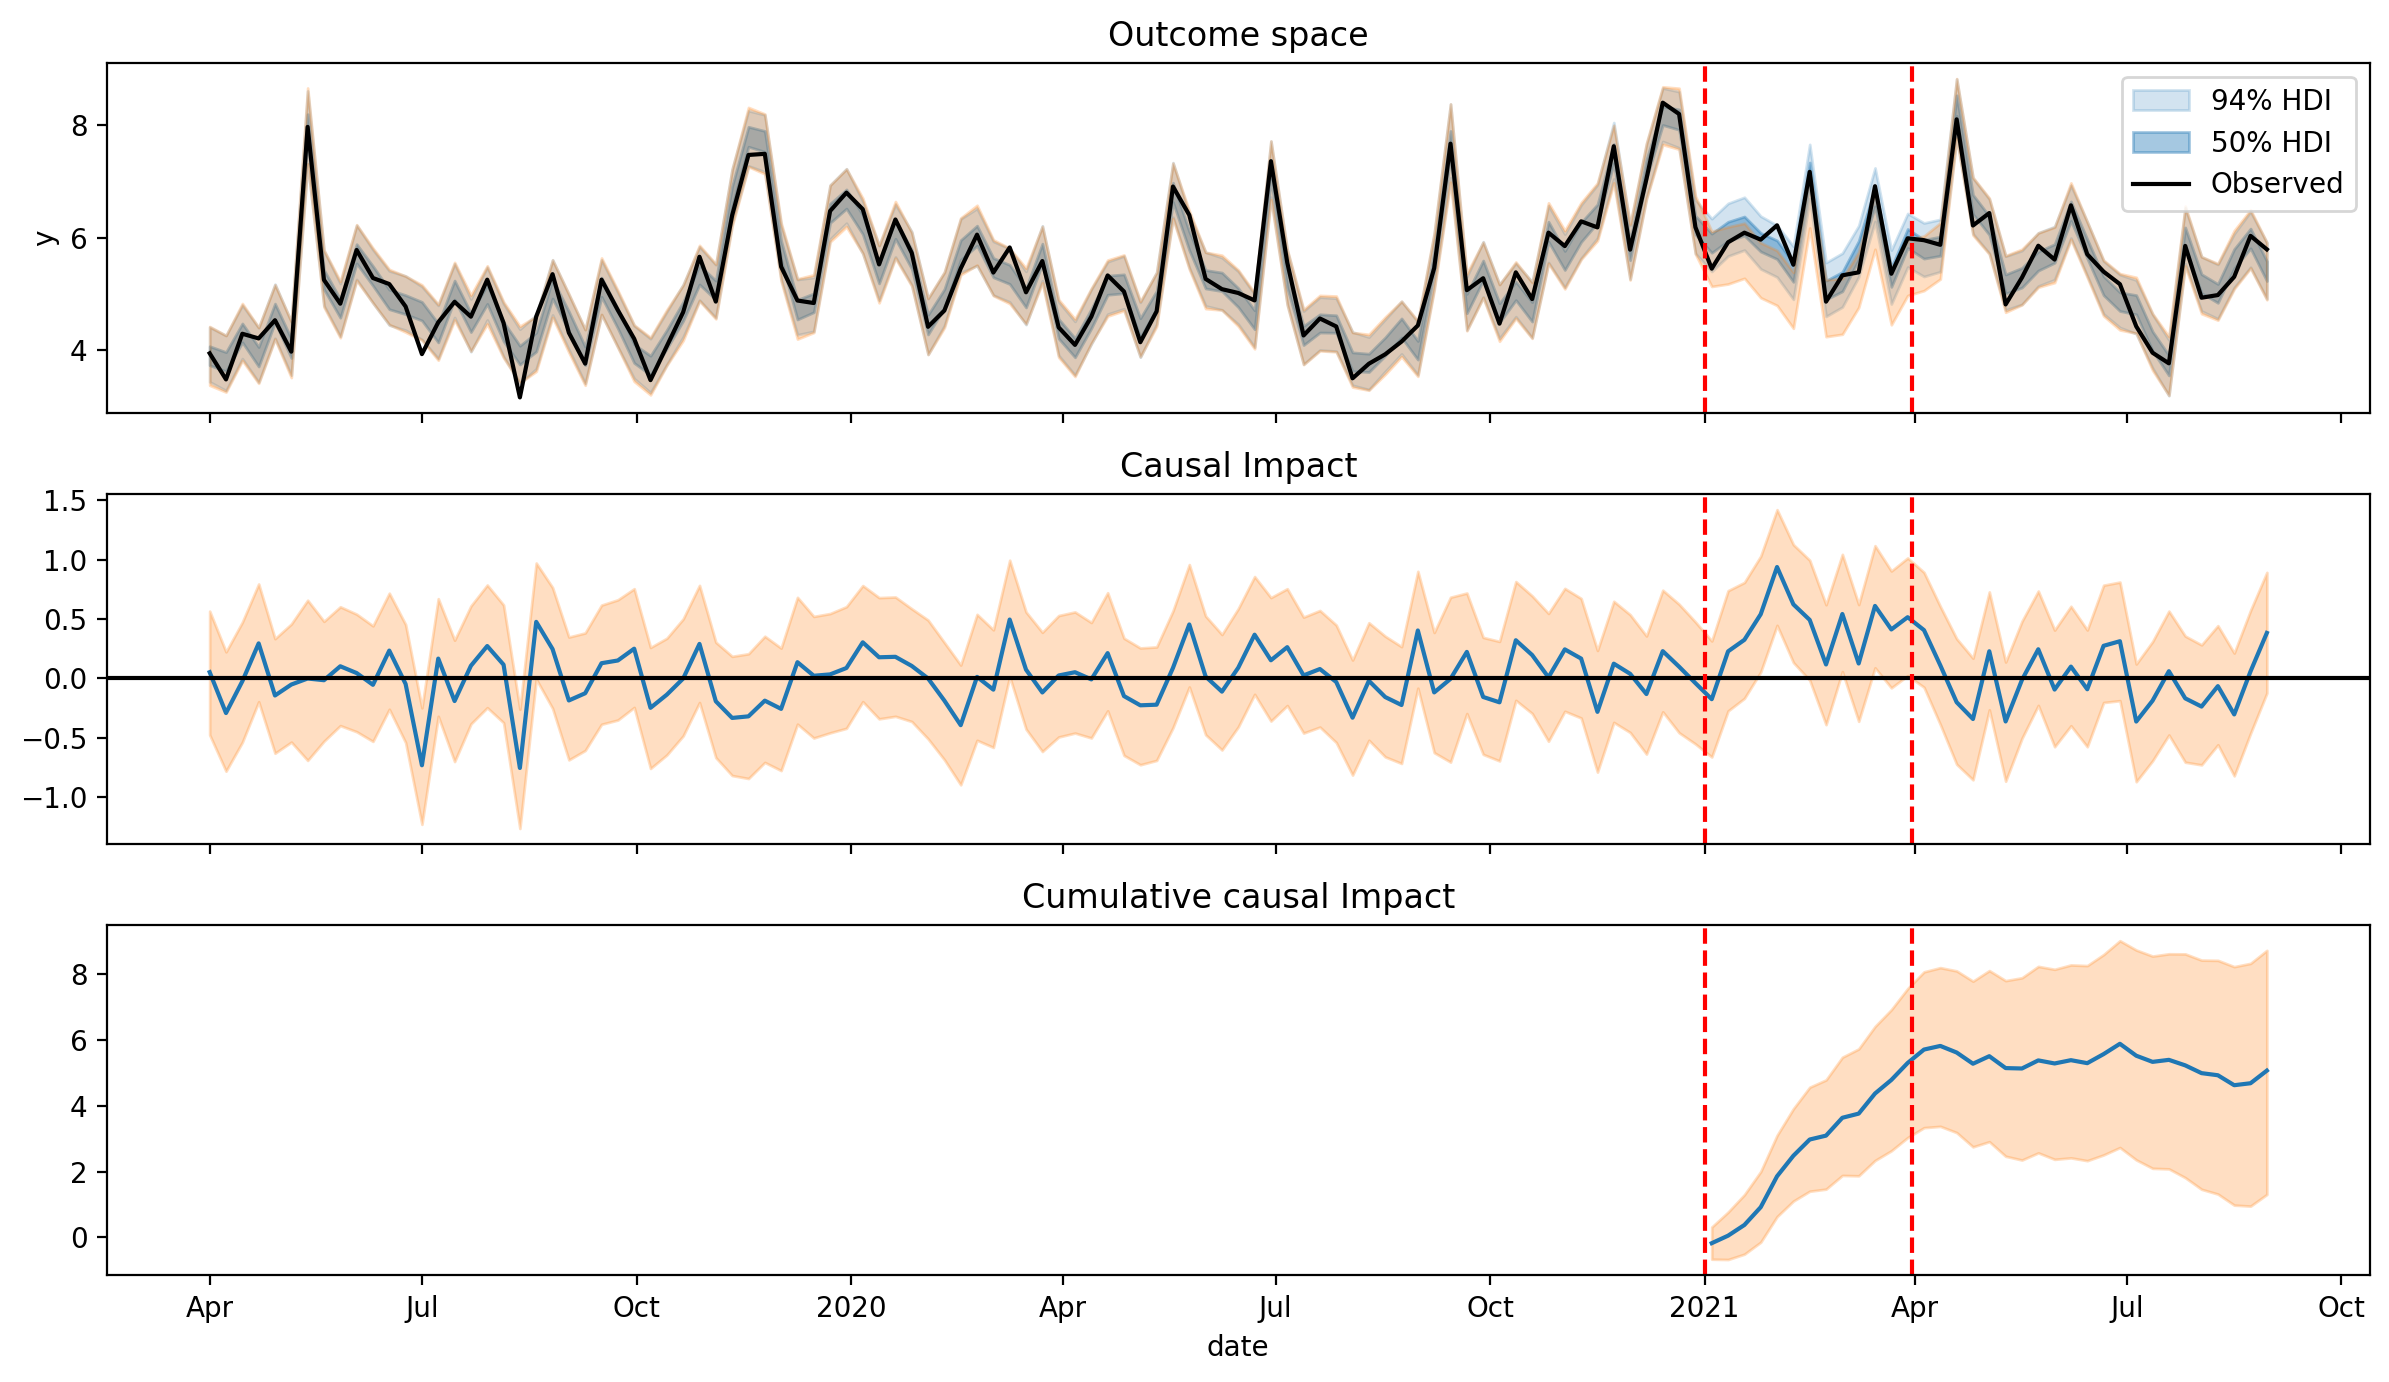

In [14]:
fig, ax = plt.subplots(3, 1, sharex=True)

# TOP PLOT - OUTCOME SPACE -------------------------------------------------------------
mmm.plot_posterior_predictive(original_scale=True, ax=ax[0])

# plot counterfactual
y_counterfactual["y"].quantile([0.025, 0.975], dim=["sample"])
ax[0].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.025}),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[0].set(title="Outcome space", xlabel="")

# BOTTOM PLOT - COUNTERFACTUAL SPACE ---------------------------------------------------
ax[1].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
# plot posterior predictive mean
causal_impact.mean(dim="sample").plot(ax=ax[1], label="casual impact mean")
ax[1].axhline(y=0, color="black", label="zero")
ax[1].set(title="Causal Impact", xlabel="")

# BOTTOM PLOT - CUMULATIVE CAUSAL IMPACT ---------------------------------------------------
# select X_counterfactual where date_week is greater than intervention_date
_X_counterfactual = X_counterfactual[
    X_counterfactual["date_week"] >= intervention_dates[0]
]
# select counterfactual where date_week is greater than intervention_date
_causal_impact = causal_impact.sel({"date": slice(intervention_dates[0], None)})
cum_causal_impact = _causal_impact.cumsum(dim="date")
ax[2].plot(
    _X_counterfactual["date_week"], cum_causal_impact.mean(dim="sample"), label="mean"
)
ax[2].fill_between(
    _X_counterfactual["date_week"].dt.to_pydatetime(),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[2].set(title="Cumulative causal Impact", xlabel="date")

# plot intervention point
for i in [0, 1, 2]:
    plot_intervention_dates(intervention_dates, ax[i])

plt.tight_layout();

**Top plot:** The top plot shows the actual sales data (black line), the posterior predicted sales under the actual scenario (blue shaded region), and the posterior predicted sales under the counterfactual scenario (orange shaded region). We might be able to see that the model predicts lower sales in the counterfactual scenario than in the actual scenario. This makes sense because the counterfactual scenario is one where we did not conduct the marketing campaign - so lower sales in this case would be expected.

**Middle plot:** The middle plot shows the difference between the actual and counterfactual sales. This is the causal impact of the marketing campaign. We can see that the model predicts a positive causal impact of the marketing campaign. We can also see that the model predicts negligible causal impact of the marketing capaign before the campaign started - this makes total sense but it is important to check that we don't have some unexpected causal impact before the campaign started.

**Bottom plot:** The bottom plot shows the cumultive causal impact from the start of the campaign.

Finally, because we simulated the data we know the true causal impact of the marketing campaign. We can compare this to the causal impact estimated by the MMM through counterfactual reasoning. So as part of a parameter recovery process - if the MMM is doing a good job of estimating the causal impact, then we can have greater confidence in the MMM's ability to estimate the causal impact of the marketing campaign on real data.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_86035/719819949.py:15: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  _X_counterfactual["date_week"].dt.to_pydatetime(),


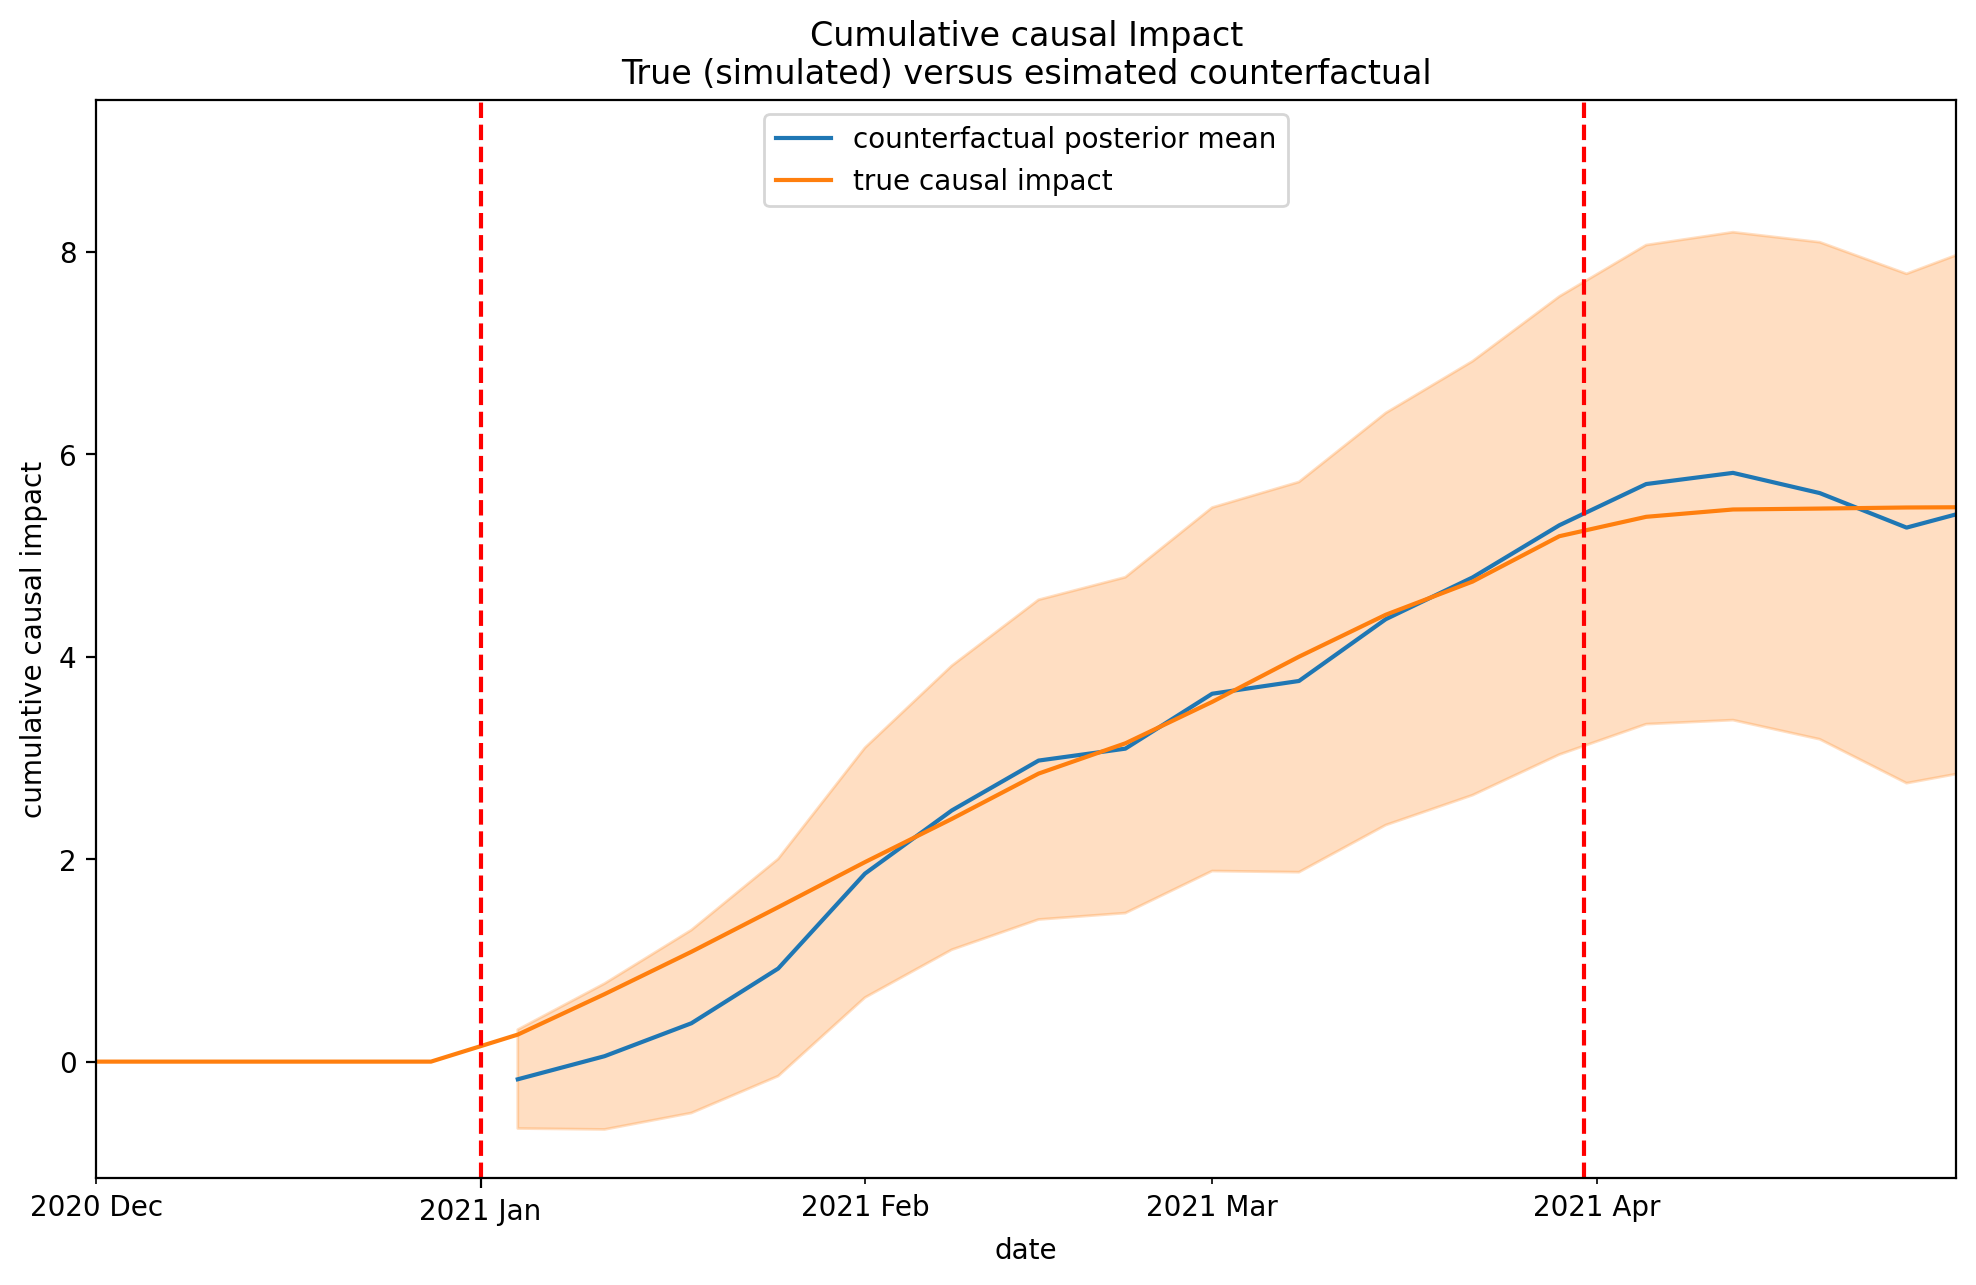

In [15]:
fig, ax = plt.subplots()

# BOTTOM PLOT - CUMULATIVE CAUSAL IMPACT ---------------------------------------------------
# select X_counterfactual where date_week is greater than intervention_date
_X_counterfactual = X_counterfactual[
    X_counterfactual["date_week"] >= intervention_dates[0]
]
# select counterfactual where date_week is greater than intervention_date
_causal_impact = causal_impact.sel({"date": slice(intervention_dates[0], None)})
cum_causal_impact = _causal_impact.cumsum(dim="date")
ax.plot(
    _X_counterfactual["date_week"],
    cum_causal_impact.mean(dim="sample"),
    label="counterfactual posterior mean",
)
ax.fill_between(
    _X_counterfactual["date_week"].dt.to_pydatetime(),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
)
ax.set(title="Cumulative causal Impact", xlabel="date")


# calculate true causal impact
new_df = pd.DataFrame()
new_df["date_week"] = df_actual["date_week"]
new_df["true_causal_impact"] = df_actual["y"] - df_counterfactual["y"]
new_df["true_cumulative_causal_impact"] = new_df["true_causal_impact"].cumsum()

sns.lineplot(
    x="date_week",
    y="true_cumulative_causal_impact",
    data=new_df,
    label="true causal impact",
)

# plot intervention point
plot_intervention_dates(intervention_dates, ax)
ax.set(
    ylabel="cumulative causal impact",
    title="Cumulative causal Impact\nTrue (simulated) versus esimated counterfactual",
)


# set xlim range to focus a bit before and after the intervention dates
def extend_date_range(intervention_dates, months_previous=1, months_after=1):
    if len(intervention_dates) != 2:
        raise ValueError("The list must contain exactly two pandas date times.")

    start_date, end_date = intervention_dates
    extended_start_date = start_date - pd.DateOffset(months=months_previous)
    extended_end_date = end_date + pd.DateOffset(months=months_after)
    return [extended_start_date, extended_end_date]


ax.set(xlim=extend_date_range(intervention_dates))

# Format x-axis date labels to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())

Overall, that's pretty good. The counterfactual posterior distribution is roughly centered around the true causal impact and well within the 94% credible interval.

## Summary

In this notebook, we've recapped Pearl's causal ladder and seen how different levels of causal reasoning can be applied to solve business problems with MMMs. We've seen how MMMs can be used to predict future sales (Step 1), optimize marketing spend (Step 2), and evaluate the impact of marketing campaigns (Step 3). We focussed on the latter as there are other notebooks which already focus on Steps 1 & 2. 

We saw how counterfactual inference can be used to estimate the causal impact of marketing campaigns. In this notebook we used "God Mode" to simulate a world where we had knowledge of the counterfactual scenario - but in real world use cases we may have to estimate what the media spend would have been had we not run a maketing campaign.

Of course, the methods demonstrated here can be used in other ways. An immediate one that comes to mind is to evalute the causal impact of our past media spending by comparing it to a counterfacutal scenario of zero media spend (on one or multiple channels), for example.

We hhope you see how this can a powerful tool for businesses to understand the impact of their marketing efforts and make data-driven decisions.

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Mon Sep 16 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.27.0

pymc_marketing: 0.8.0
pytensor      : 2.20.0

pandas    : 2.2.2
matplotlib: 3.9.2
xarray    : 2024.9.0
numpy     : 1.26.4
seaborn   : 0.13.2

Watermark: 2.4.3

